In [1]:
import sys
sys.path.append('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project')
import numpy as np
import pandas as pd
import random

# Setup plotting with matplotlib
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
## setup latex plotting
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
## make font size bigger
matplotlib.rcParams.update({'font.size': 16})
## but make legend smaller
matplotlib.rcParams.update({'legend.fontsize': 14})
## change line thickness
matplotlib.rcParams.update({'lines.linewidth' : 1.75})

import Hyperparam_Testing.Testing_Notebooks.chirallag as cL
import Hyperparam_Testing.Testing_Notebooks.Common_Functions as cf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import scipy.stats as stats
from numpy.lib.stride_tricks import sliding_window_view
from scipy.optimize import curve_fit as fit

In [2]:
N=3
gens = cL.gen_gellman(3)
F0 = 1



def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
liststrucSU3 = np.array([[1,2,3,1],[1,4,7,.5],[1,5,6,-.5],[2,4,6,.5],[2,5,7,.5],[3,4,5,.5],[3,6,7,-.5],[4,5,8,3**0.5/2],[6,7,8,3**0.5/2]])
liststrucSU2 = np.array([[1,2,3,1],[3,2,1,1]])

def adjointSUN(dim,liststruc):
    dimSUN=dim**2-1
#     admat = np.zeros((8,8,8))
    admat = np.zeros((dimSUN,dimSUN,dimSUN))
    for i in range(liststruc.shape[0]):
        strucc = liststruc[i]
        strucc1 = int(strucc[0])-1
        strucc2 = int(strucc[1])-1
        strucc3 = int(strucc[2])-1
        admat[strucc1,strucc2,strucc3]=strucc[3]
        admat[strucc1,strucc3,strucc2]=-strucc[3]
        admat[strucc3,strucc1,strucc2]=strucc[3]
        admat[strucc3,strucc2,strucc1]=-strucc[3]
        admat[strucc2,strucc3,strucc1]=strucc[3]
        admat[strucc2,strucc1,strucc3]=-strucc[3]
    return admat

adjointSU3 = adjointSUN(3,liststrucSU3)

In [3]:
# To do, make these work when not supplying stacks of epsilon and transformations.

def get_SO_trans(eps,N):
    ''' Produces 'infinitesimal' transformation matrices for SO(N) given epsilon.
        Epsilon is size of transformation and should be a numpy array of dimension 1.
        N must be larger than 1.
    '''
    
    trans_number = len(eps) 
    # Generate rotation matrices
    SO_samp = np.zeros((trans_number,N,N))

    # Set random off diagonal element of each matrix to one (surely must be a better way to do this)
    poss_inds = range(N)
    SO_inds = [random.sample(poss_inds,2) for i in range(trans_number)]
    SO_indsflat = [i*(N)**2+x*(N)+y for i,(x,y) in enumerate(SO_inds)]
    SO_samp.flat[SO_indsflat] += 1

    # Is this transpose faster than repeating assignment above?
    SO_samp = SO_samp - np.transpose(SO_samp,axes=[0,2,1])
    SO_trans = np.identity(N) + eps[:,None,None]*SO_samp
    # Normalise so that det = 1
    #norm = np.power(np.linalg.det(SO_trans),-1/(N))
    #SO_trans = norm[:,None,None]*SO_trans
    return SO_trans
  
def get_SU_trans(eps,N,liststruct):
    ''' Produces 'infinitesimal' transformation matrices for SO(N) given epsilon.
        Epsilon is size of transformation and should be a numpy array of dimension 1.
        N must be larger than 1.
        Calls adjointSUN which requires liststruct
    '''
    adjointSU = adjointSUN(N,liststruct)
    
    genno=np.random.randint(0,N*N-2,number_predictions)
    SU_trans = np.identity(N*N-1)+eps[:,None,None]*adjointSU[genno]
    # Normalise so that det = 1
    #norm = np.power(np.linalg.det(SU_trans),-1/(N*N-1))
    #SU_trans = norm[:,None,None]*SU_trans
    return SU_trans
    
def apply_trans(trans,vec):
    ''' Apply transformation trans to vector. Assumes both trans and vec are stacks.'''
    trans_vec=np.matmul(trans,vec[:,:,None]).squeeze()
    return trans_vec
    


In [4]:
# Compare Transformations
epsmax = 100
epsmin = 0.001
eps_intervals=200
number_predictions=100000


pi=np.random.rand(number_predictions,N*N-1)
dpi=np.random.rand(number_predictions,N*N-1)

# Get epsilons, create copies
eps_vals=np.logspace(np.log10(epsmin),np.log10(epsmax),num=eps_intervals)
eps = np.zeros(number_predictions)
for i,val in enumerate(eps_vals): 
    eps[i*int(number_predictions/eps_intervals):(i+1)*int(number_predictions/eps_intervals)] = val
# Set leftovers to max value
eps[(i+1)*int(number_predictions/eps_intervals):]=val

# SO(N) transformations
SO_trans = get_SO_trans(eps,N*N-1)

SO_pi = apply_trans(SO_trans,pi)
SO_dpi = apply_trans(SO_trans,dpi)

# SU(N) transformations

SU_trans = get_SU_trans(eps,N,liststrucSU3)

SU_pi = apply_trans(SU_trans,pi)
SU_dpi = apply_trans(SU_trans,dpi)


# Get potential values, only care about real part (non zero imag should just be numerical precision errors)

orig_V = cL.get_V(pi,dpi,gens,F0).real
SO_V = cL.get_V(SO_pi,SO_dpi,gens,F0).real
SU_V = cL.get_V(SU_pi,SU_dpi,gens,F0).real

SO_Vdiff = (SO_V - orig_V)/orig_V
SU_Vdiff = (SU_V - orig_V)/orig_V

rand_means = np.mean(np.hstack([np.abs(pi) , np.abs(dpi)]),axis=-1)


In [5]:
print("Average error of SU(3) transformation: ",np.mean(np.abs(SU_Vdiff)),
      ", and of rotation: ",np.mean(np.abs(SO_Vdiff)))

print("Average potential value: ",np.mean(np.abs(orig_V)),", average pion value:",np.mean(rand_means))

Average error of SU(3) transformation:  384271.11685120355 , and of rotation:  110146.22936452848
Average potential value:  0.19400669427896525 , average pion value: 0.49969971860292556


(0.001, 1)

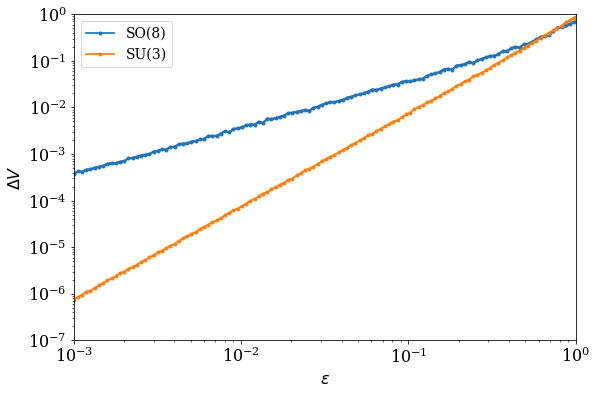

In [6]:
# Standard error by hand to compare with seaborn lineplot

fig,ax = plt.subplots(1,figsize=(9,6))

# Evaluate std deviation is epsilon is created using interval
SO_Vdiff_eps = [np.abs(SO_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SO = np.mean(SO_Vdiff_eps,axis=-1)
std_dev_SO = np.std(SO_Vdiff_eps,axis=-1)
std_error_SO = std_dev_SO/np.sqrt([len(s) for s in SO_Vdiff_eps])
SU_Vdiff_eps = [np.abs(SU_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SU = np.mean(SU_Vdiff_eps,axis=-1)
std_dev_SU = np.std(SU_Vdiff_eps,axis=-1)
std_error_SU = std_dev_SU/np.sqrt([len(s) for s in SU_Vdiff_eps])
#print(std_dev_SU)

#print(std_error_SU)
ax.plot(eps_vals,mean_SO,marker='.',label='SO({:})'.format(N*N-1))
ax.plot(eps_vals,mean_SU,marker='.',label='SU({:})'.format(N))
Range = 1
ax.fill_between(eps_vals,mean_SO-Range*std_error_SO, mean_SO+Range*std_error_SO,color='blue',alpha=0.5)
ax.fill_between(eps_vals,mean_SU-Range*std_error_SU, mean_SU+Range*std_error_SU,color='orange',alpha=0.5)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylim(1e-7,1)
ax.set_xlim(1e-3,1)

#fig.tight_layout()
#fig.savefig('DeltaV.png',dpi=200)

In [7]:
###Find offsets so fit lines line up
so_grad, so_intercept,_,_,_ = stats.linregress(eps_vals,abs(mean_SO))
su_intercept = 10**stats.linregress(np.log10(eps_vals),np.log10(abs(mean_SU)))[0]

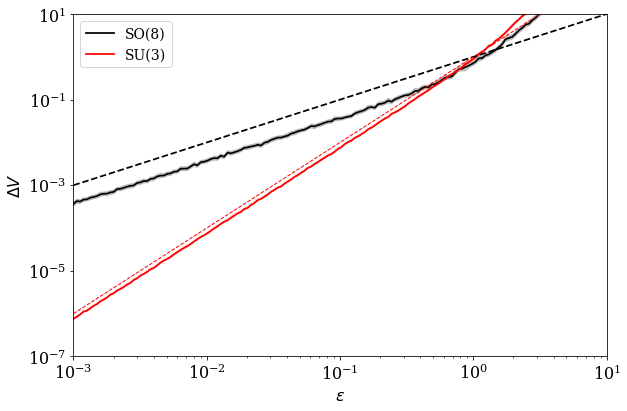

In [8]:
fig,ax = plt.subplots(1,figsize=(9,6))


data = pd.DataFrame({'epsilon':eps,'SOdiff':np.abs(SO_Vdiff),'SUdiff':np.abs(SU_Vdiff)})
sb.lineplot(data=data,x='epsilon',y='SOdiff',label='SO({:})'.format(N*N-1),ci=99,color = 'black' )
sb.lineplot(data=data,x='epsilon',y='SUdiff',label='SU({:})'.format(N),ci=99, color = 'Red')



x = np.logspace(-3,1,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
#ax.plot(x,y,color="green")
ax.plot(x,x,color="Black",linestyle='--')
ax.grid(False)
#ax.plot(x,y1,color="orange")
ax.plot(x,(x**2),color="Red",linestyle='--',linewidth = 1)


ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)
ax.legend()
ax.set_ylim(1e-7,10)
ax.set_xlim(1e-3,10)
fig.tight_layout()
fig.savefig('DeltaV.jpeg',dpi=200,transparent=False)

In [9]:
data.to_csv('../Training_Data/symetric_training_data_epsilon_and_vdiff.csv')

In [10]:
[[train_x,train_y],[val_x,val_y]]= cf.gen_and_load(10**5,10**3)

In [11]:
inital_model = models.Sequential()
inital_model.add(layers.Input(train_x.shape[1]))
inital_model.add(layers.Dense(60,activation='relu'))
inital_model.add(layers.Dense(60,activation='relu'))
inital_model.add(layers.Dense(1))
inital_model.compile(optimizer = 'Adam',loss = 'mape', metrics = [['mean_absolute_error'],['mean_absolute_percentage_error']])
inital_model.summary()

epochs = 50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,741
Trainable params: 4,741
Non-trainable params: 0
_________________________________________________________________


2022-02-09 18:25:46.984654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 18:25:46.990544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 18:25:46.990944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 18:25:46.991562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
history = inital_model.fit(train_x,train_y,validation_data = (val_x,val_y),batch_size= 256, epochs =epochs)

2022-02-09 18:25:47.317309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 47.5704 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 47.5704 - val_loss: 31.4456 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 31.4456
Epoch 2/50
387/387 [==============================] - 0s 1ms/step - loss: 25.0293 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 25.0293 - val_loss: 22.2233 - val_mean_absolute_error: 0.0250 - val_mean_absolute_percentage_error: 22.2233
Epoch 3/50
387/387 [==============================] - 0s 1ms/step - loss: 18.0274 - mean_absolute_error: 0.0228 - mean_absolute_percentage_error: 18.0274 - val_loss: 16.0417 - val_mean_absolute_error: 0.0213 - val_mean_absolute_percentage_error: 16.0417
Epoch 4/50
387/387 [==============================] - 0s 1ms/step - loss: 16.4973 - mean_absolute_error: 0.0204 - mean_absolute_percentage_error: 16.4973 - val_loss: 15.7394 - val_mean_absolute_error: 0.0188 - val_mean_absolute_percentage

In [13]:
validation_MAPE = history.history['val_mean_absolute_percentage_error']


In [14]:
test_data= cf.gen_and_load(10**5,0) 

In [15]:
### Generate New test data for nn prediction
pi_dpi,v = test_data[1]
pis =pi_dpi[:,:8]
dpis = pi_dpi[:,8:]

SU_dpi_nn = apply_trans(SU_trans,dpis)
SU_pi_nn = apply_trans(SU_trans,pis)
SU_pi_dpi_nn = np.hstack((SU_pi_nn,SU_dpi_nn))
SU_V_nn_test = cL.get_V(SU_pi_nn,SU_dpi_nn,gens,F0).real
###I only want the transformed data on the interval 0-1


In [16]:
print('Range of Pi\' fields',np.min(SU_pi_dpi_nn),'to',np.max(SU_pi_dpi_nn))
print('Mean Pi\' Field', np.mean(SU_pi_dpi_nn))
print('Range of Pi fields',np.min(pi_dpi),'to',np.max(pi_dpi))

Range of Pi' fields -133.40917261355168 to 135.71783190295014
Mean Pi' Field 0.8010622268997727
Range of Pi fields 0.01619692990061416 to 0.9999996756927135


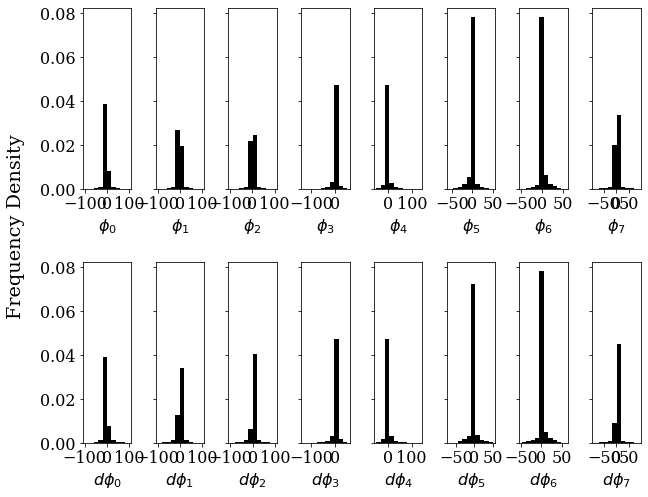

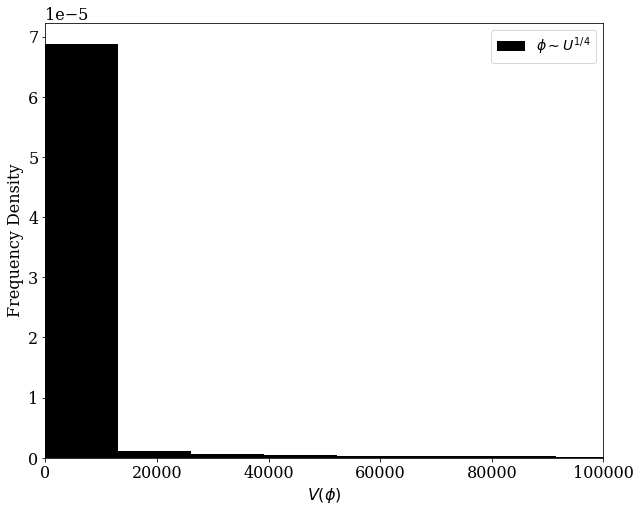

In [17]:

fig , ax = plt.subplots(2,8,sharey= True, figsize = (10,8))
plt.subplots_adjust(hspace= 0.4,wspace= 0.5)
for i in range(8):
    ax[0,i].hist(SU_pi_dpi_nn[:,i], density = True, color = 'black') 
    #ax[0,i].set_xticks([0,1])
    #ax[1,i].set_xticks([0,1])
    ax[1,i].hist(SU_pi_dpi_nn[:,8+i],density = True, color = 'black')
    ax[0,i].set_xlabel('$\phi_{{{}}}$'.format(i))
    ax[1,i].set_xlabel('$d\phi_{{{}}}$'.format(i))
fig.supylabel('Frequency Density')
fig_2 = plt.figure(figsize= (10,8))
plt.hist(abs(SU_V_nn_test),density= True, bins = 1000, color = 'black',label=  '$\phi \sim U^{1/4}$')
#plt.hist(df_SU_pi_dpi_nn[:,-1],density= True, bins = 1000, color = 'blue',label=  '$\phi \sim U^{1/4}$' )
plt.xlabel('$V(\phi)$')
plt.ylabel('Frequency Density')
plt.xlim(0,10**5)
plt.legend()



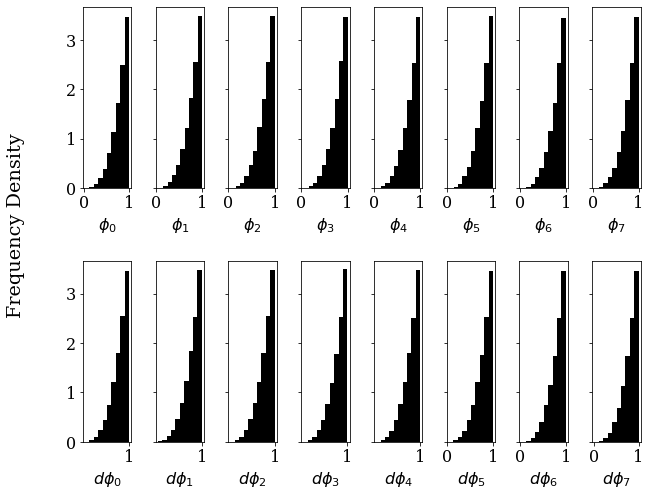

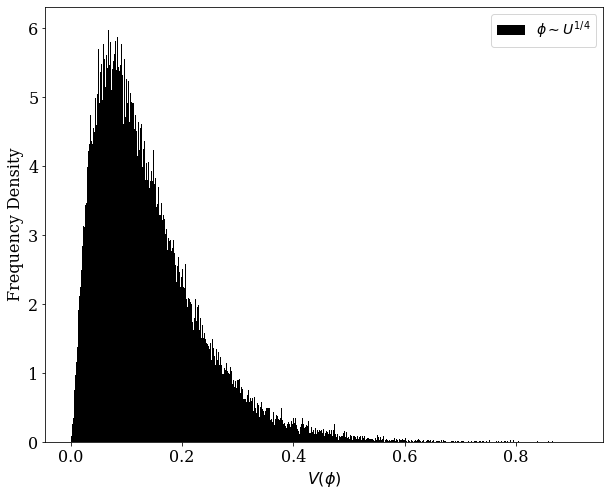

In [18]:
cf.field_plotter(pi_dpi,v)

In [19]:
#Use Neural network to predict transformation
#Delta Vnn calculated for plotting 
V_nn = inital_model.predict(SU_pi_dpi_nn)
delta_V_nn = abs((V_nn[:,0]-v)/v)

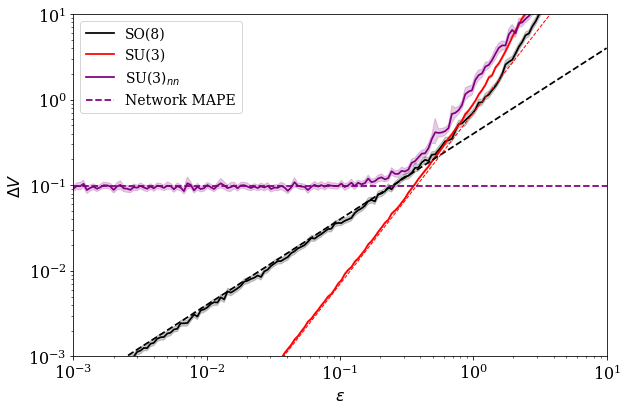

In [20]:
fig,ax = plt.subplots(1,figsize=(9,6))


data = pd.DataFrame({'epsilon':eps,'SOdiff':np.abs(SO_Vdiff),'SUdiff':np.abs(SU_Vdiff),'SUdiff_nn':np.abs(delta_V_nn)})
sb.lineplot(data=data,x='epsilon',y='SOdiff',label='SO({:})'.format(N*N-1),ci=95,color = 'black' )
sb.lineplot(data=data,x='epsilon',y='SUdiff',label='SU({:})'.format(N),ci=95, color = 'Red')
sb.lineplot(data=data,x='epsilon',y='SUdiff_nn',label='SU({}'.format(N)+'$)_{nn}$',ci=95, color = 'Purple')


x = np.logspace(-3,1,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
#ax.plot(x,y,color="green")
ax.plot(x,x*0.4,color="Black",linestyle='--')
ax.grid(False)
#ax.plot(x,y1,color="orange")
ax.plot(x,(x**2)*0.7,color="Red",linestyle='--',linewidth = 1)
ax.plot(x,np.ones_like(x)*validation_MAPE[-2]/100, color = 'purple',linestyle = '--', label = 'Network MAPE')

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)
ax.legend()
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-3,10)
fig.tight_layout()
fig.savefig('DeltaV_inital.jpeg',dpi=200,transparent=False)

In [21]:
model = keras.models.load_model('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Optimised_Network/Saved_Optimised_Networks/106datapoints.h5')

In [22]:
pred_V = model.predict(pi_dpi)[:,0]
MAPE = np.mean(abs((pred_V - v)/v))
print('MAPE = ',round(MAPE*100,2))

MAPE =  2.97


In [23]:
V_nn = model.predict(SU_pi_dpi_nn)
print(V_nn)
print(V_nn[:,0].shape)
delta_V_nn = abs((V_nn[:,0]-v)/v)

[[5.7218697e-02]
 [2.8762600e-01]
 [5.9154712e-02]
 ...
 [1.1331419e+02]
 [9.8800568e+01]
 [1.3837584e+02]]
(100000,)


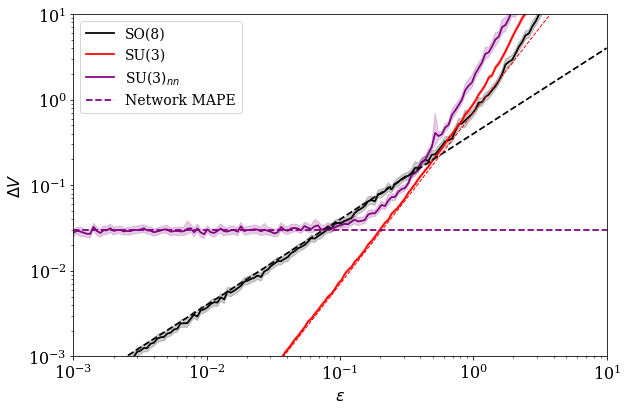

In [24]:
fig_2,ax = plt.subplots(1,figsize=(9,6))
data = pd.DataFrame({'epsilon':eps,'SOdiff':np.abs(SO_Vdiff),'SUdiff':np.abs(SU_Vdiff),'SUdiff_nn':np.abs(delta_V_nn)})
sb.lineplot(data=data,x='epsilon',y='SOdiff',label='SO({:})'.format(N*N-1),ci=99,color = 'black' )
sb.lineplot(data=data,x='epsilon',y='SUdiff',label='SU({:})'.format(N),ci=99, color = 'Red')
sb.lineplot(data=data,x='epsilon',y='SUdiff_nn',label='SU({}'.format(N)+'$)_{nn}$',ci=99, color = 'Purple')


x = np.logspace(-3,1,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
#ax.plot(x,y,color="green")
ax.plot(x,x*0.4,color="Black",linestyle='--')
ax.grid(False)
#ax.plot(x,y1,color="orange")
ax.plot(x,(x**2)*0.7,color="Red",linestyle='--',linewidth = 1)
ax.plot(x,np.ones_like(x)*MAPE, color = 'purple',linestyle = '--', label = 'Network MAPE')

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)
ax.legend()
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-3,10)
fig_2.tight_layout()
fig_2.savefig('DeltaV_improved.jpeg',dpi=200,transparent=False)

In [25]:
coef_su = np.polyfit(eps_vals, mean_SU,3)
for i,ii in enumerate(coef_su):
    print('a{}'.format(i)+'='+str(ii))

a0=27.04106056809679
a1=-1347.7881729524138
a2=18634.66003366312
a3=-13287.085255336977


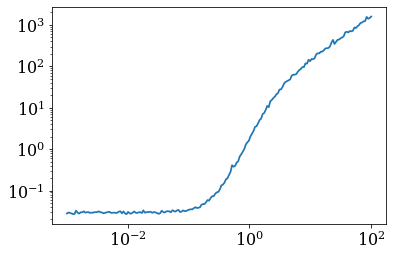

In [26]:
plt.loglog(eps_vals,np.mean([np.abs(delta_V_nn[np.where(eps==val)]) for val in eps_vals],axis = 1))


(0.001, 10)

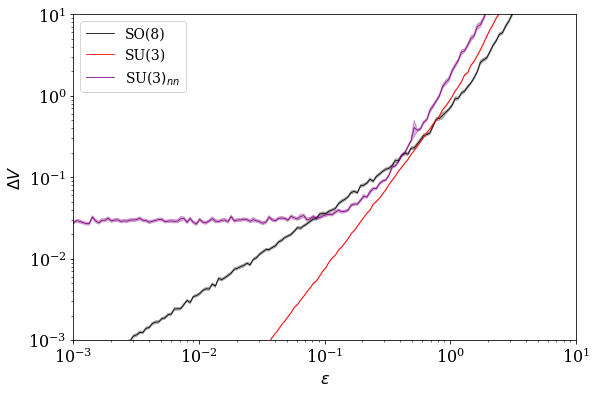

In [66]:

fig,ax = plt.subplots(1,figsize=(9,6))

SO_Vdiff_eps = [np.abs(SO_Vdiff[np.where(eps==val)]) for val in eps_vals] ##subsampling only the points which have epsilon values
mean_SO = np.mean(SO_Vdiff_eps,axis=-1)
std_dev_SO = np.std(SO_Vdiff_eps,axis=-1)
std_error_SO = std_dev_SO/np.sqrt([len(s) for s in SO_Vdiff_eps])
SU_Vdiff_eps = [np.abs(SU_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SU = np.mean(SU_Vdiff_eps,axis=-1)
std_dev_SU = np.std(SU_Vdiff_eps,axis=-1)
std_error_SU = std_dev_SU/np.sqrt([len(s) for s in SU_Vdiff_eps])
nn_eps = [np.abs(delta_V_nn[np.where(eps==val)]) for val in eps_vals]
mean_nn = np.mean(nn_eps,axis = -1)
std_nn = np.std(nn_eps,axis =-1)
ste_nn = std_nn/np.sqrt([len(s) for s in nn_eps])

ax.plot(eps_vals,mean_SO,marker='',label='SO({:})'.format(N*N-1),c = 'black',linewidth = 0.8)
ax.plot(eps_vals,mean_SU,marker='',label='SU({:})'.format(N),c = 'red',linewidth = 0.8)
ax.plot(eps_vals,mean_nn,marker='',label='SU({:}'.format(N)+'$)_{nn}$', color = 'purple',linewidth = 0.8)
Range = 1
ax.fill_between(eps_vals,mean_SO-Range*std_error_SO, mean_SO+Range*std_error_SO,color='black',linewidth = 0.6,alpha=0.3)
ax.fill_between(eps_vals,mean_SU-Range*std_error_SU, mean_SU+Range*std_error_SU,color='red',linewidth = 0.6,alpha=0.3)
ax.fill_between(eps_vals,mean_nn-Range*ste_nn, mean_nn+Range*ste_nn,color='purple',alpha=0.3,)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-3,10)

(0.001, 1.0)

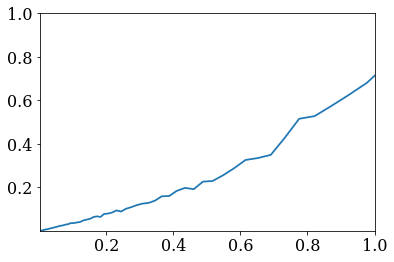

In [67]:
fig, ax = plt.subplots()
mean_nn.shape
ax.plot(eps_vals,mean_SO)
ax.set_ylim(1e-3,1)
ax.set_xlim(1e-3,1)

In [68]:
# Create windows
def p5(x,a0,a1,a2,a3,a4,a5):
    return a0+x*a1+a2*x**2+a3*x**3+a4*x**4+a5*x**5

p0 = np.zeros(6)
window = 33
step=1

eps_windowed = sliding_window_view(eps_vals,window)[::step]
mean_SO_windowed = sliding_window_view(mean_SO,window)[::step]
mean_SU_windowed = sliding_window_view(mean_SU,window)[::step]
#mean_arb_windowed = sliding_window_view(mean_arb,window)[::step]

#mean_SO_network_windowed = sliding_window_view(mean_SO_network,window)[::step]
mean_SU_network_windowed = sliding_window_view(mean_nn,window)[::step]
#mean_arb_network_windowed = sliding_window_view(mean_arb_network,window)[::step]


std_error_SO_windowed = sliding_window_view(std_error_SO,window)[::step]
std_error_SU_windowed = sliding_window_view(std_error_SU,window)[::step]
#std_error_arb_windowed = sliding_window_view(std_error_arb,window)[::step]

#std_error_SO_network_windowed = sliding_window_view(std_error_SO_network,window)[::step]
std_error_SU_network_windowed = sliding_window_view(mean_nn,window)[::step]
#td_error_arb_network_windowed = sliding_window_view(std_error_arb_network,window)[::step]

In [69]:
SO_fits=np.zeros((eps_windowed.shape[0],len(p0)))
SU_fits=np.zeros((eps_windowed.shape[0],len(p0)))
arb_fits=np.zeros((eps_windowed.shape[0],len(p0)))

SO_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))
SU_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))
arb_network_fits=np.zeros((eps_windowed.shape[0],len(p0)))


SO_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
SU_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
#arb_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))

#SO_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
SU_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))
#arb_network_covs=np.zeros((eps_windowed.shape[0],len(p0),len(p0)))

bound = (-0.01,10)
for i,these_eps_vals in enumerate(eps_windowed):
    #print(i/len(eps_windowed))
    SO_fit_params,SO_fit_cov=fit(p5,these_eps_vals,mean_SO_windowed[i],p0=p0,
                                                      sigma=std_error_SO_windowed[i],absolute_sigma=True,bounds=bound)
    SU_fit_params,SU_fit_cov=fit(p5,these_eps_vals,mean_SU_windowed[i],p0=p0,
                                                      sigma=std_error_SU_windowed[i],absolute_sigma=True,bounds=bound)
    
    
    SU_network_fit_params,SU_network_fit_cov=fit(p5,these_eps_vals,mean_SU_network_windowed[i],
                                                                    p0=p0,sigma=std_error_SU_network_windowed[i],absolute_sigma=True,
                                                                    bounds=bound)
    

    SO_fits[i]=(SO_fit_params)
    SO_covs[i]=(SO_fit_cov)
    SU_fits[i]=(SU_fit_params)
    SU_covs[i]=(SU_fit_cov)
    

    #SO_network_fits[i]=(SO_network_fit_params)
    #SO_network_covs[i]=(SO_network_fit_cov)
    SU_network_fits[i]=(SU_network_fit_params)
    SU_network_covs[i]=(SU_network_fit_cov)
    #arb_network_fits[i]=(arb_network_fit_params)
    #arb_network_covs[i]=(arb_network_fit_cov)

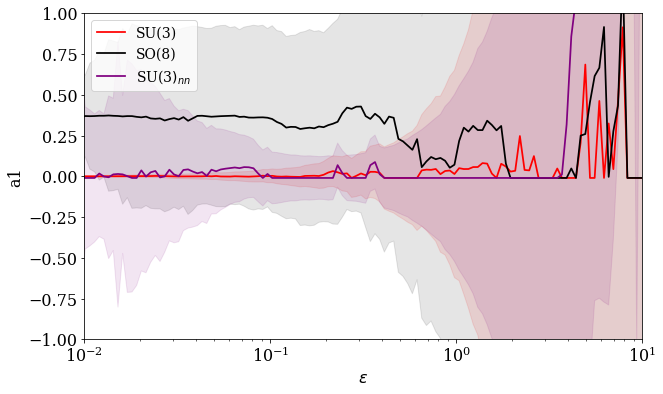

In [71]:
# Now SU(3)
fig,ax = plt.subplots(1,figsize=(10,6))
colors = sb.color_palette('colorblind',4)
eps_mid=np.median(eps_windowed,axis=-1)

coeff = 1
y=np.array(SU_fits)[:,coeff]
ci = np.sqrt(np.array(SU_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SU(3)',color='red')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='red', alpha=.1)


y=np.array(SO_fits)[:,coeff]
ci = np.sqrt(np.array(SO_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SO(8)',color='black')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='black', alpha=.1)
#print(y)
y=np.array(SU_network_fits)[:,coeff]
ci = 0.01*np.sqrt(np.array(SU_network_covs)[:,coeff,coeff])
ax.semilogx(eps_mid, y*np.power(eps_mid,0),label=r'SU(3$)_{nn}$',color='purple')
ax.fill_between(eps_mid, (y-ci)*np.power(eps_mid,0), (y+ci)*np.power(eps_mid,0), color='purple', alpha=.1)
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('a{}'.format(coeff))
ax.set_ylim(-1,1)
ax.set_xlim(0.01,10)
plt.legend()
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/sliding_window_a_{}.png'.format(coeff),dpi = 300)